## Лабораторная работа 6 
### Логистическая регрессия

Необходимо спрогнозировать показателей и оценки эффективности влияния социальных сетей на создание бренда

    0 пост не оплачен
    1 пост оплачен

Перед началом работы необходимо импортировать нужные библиотеки для работы.
pandas - для работы с данными
sklearn - для обучения 
numpy - для работы с массивами и матрицами
matplotlib и seaborn - для постоения красивых графиков

In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 1.	Вы работаете с файлом dataset_Facebook.csv, выполните загрузку данных из него.

In [2]:
df = pd.read_csv('dataset_Facebook.csv', delimiter  = ';')
df.head(100)

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4.0,3,0.0,2752.0,5091.0,178.0,109.0,159.0,3078.0,1640.0,119.0,4.0,79.0,17.0,100
1,139441,Status,2,12,3.0,10,0.0,10460.0,19057.0,1457.0,1361.0,1674.0,11710.0,6112.0,1108.0,5.0,130.0,29.0,164
2,139441,Photo,3,12,3.0,3,0.0,2413.0,4373.0,177.0,113.0,154.0,2812.0,1503.0,132.0,0.0,66.0,14.0,80
3,139441,Photo,2,12,2.0,10,1.0,50128.0,87991.0,2211.0,790.0,1119.0,61027.0,32048.0,1386.0,58.0,1572.0,147.0,1777
4,139441,Photo,2,12,2.0,3,0.0,7244.0,13594.0,671.0,410.0,580.0,6228.0,3200.0,396.0,19.0,325.0,49.0,393
5,139441,Status,2,12,1.0,9,0.0,10472.0,20849.0,1191.0,1073.0,1389.0,16034.0,7852.0,1016.0,1.0,152.0,33.0,186
6,139441,Photo,3,12,1.0,3,1.0,11692.0,19479.0,481.0,265.0,364.0,15432.0,9328.0,379.0,3.0,249.0,27.0,279
7,139441,Photo,3,12,7.0,9,1.0,13720.0,24137.0,537.0,232.0,305.0,19728.0,11056.0,422.0,0.0,325.0,14.0,339
8,139441,Status,2,12,7.0,3,0.0,11844.0,22538.0,1530.0,1407.0,1692.0,15220.0,7912.0,NaN,0.0,161.0,31.0,192
9,139441,Photo,3,12,6.0,10,0.0,4694.0,8668.0,280.0,183.0,250.0,4309.0,2324.0,NaN,3.0,113.0,26.0,142


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   496 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           496 non-null float64
Post Hour                                                              500 non-null int64
Paid                                                                   497 non-null float64
Lifetime Post Total Reach                                              496 non-null float64
Lifetime Post Total Impressions                                        499 non-null float64
Lifetime Engaged Users                                                 496 n

### 2.	Выполните предобработку данных – разберитесь с пропусками при их наличии, все категориальные признаки переведите в численный вид (их более одного). Удалять столбцы из датасета возможно только при наличии корреляции с данными из других столбцов.

In [4]:
df["Type"].unique()

array(['Photo', 'Status', 'Link', 'Video', nan], dtype=object)

 Я не выбираю one-hot кодирование, так как оно имеет ряд важных недостатков, а кодирую признаки на основании другого. В данном случае целевого признака. Т.е. например, - вместо Type я напишу % того, сколько постов данной категории Type имеют paid == 1. Или, вероятность того, что пост такого типа оплачен

In [5]:
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

df['Type'] = code_mean(df, 'Type', 'Paid')
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,0.276850,2,12,4.0,3,0.0,2752.0,5091.0,178.0,109.0,159.0,3078.0,1640.0,119.0,4.0,79.0,17.0,100
1,139441,0.222222,2,12,3.0,10,0.0,10460.0,19057.0,1457.0,1361.0,1674.0,11710.0,6112.0,1108.0,5.0,130.0,29.0,164
2,139441,0.276850,3,12,3.0,3,0.0,2413.0,4373.0,177.0,113.0,154.0,2812.0,1503.0,132.0,0.0,66.0,14.0,80
3,139441,0.276850,2,12,2.0,10,1.0,50128.0,87991.0,2211.0,790.0,1119.0,61027.0,32048.0,1386.0,58.0,1572.0,147.0,1777
4,139441,0.276850,2,12,2.0,3,0.0,7244.0,13594.0,671.0,410.0,580.0,6228.0,3200.0,396.0,19.0,325.0,49.0,393


Так как данных и так достаточно мало, было бы очень грубо выкидывать незаполненные строки. Так что место dropna я заполняю недостающие значения средним значением данного признака.

In [6]:
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null float64
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null float64
Post Hour                                                              500 non-null int64
Paid                                                                   500 non-null float64
Lifetime Post Total Reach                                              500 non-null float64
Lifetime Post Total Impressions                                        500 non-null float64
Lifetime Engaged Users                                                 500 

При помощи функции из документации matplotlib построим диагональное поле корреляций и оценим уровень свзи признаков с целевым

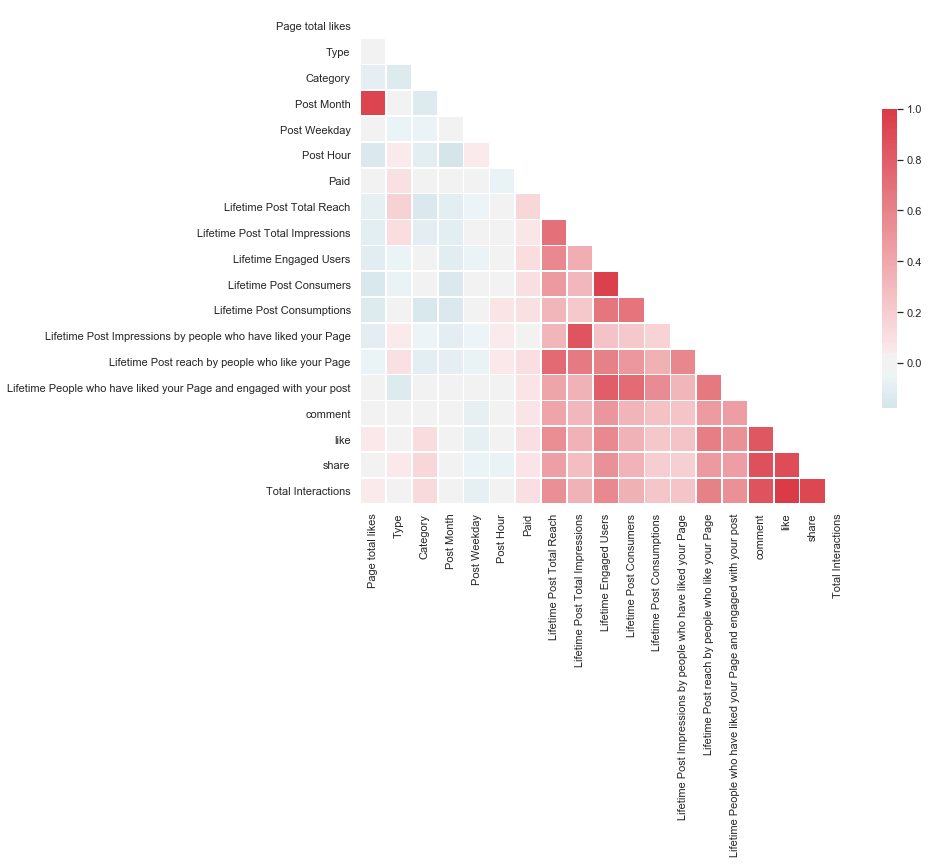

In [7]:
sns.set(style="white")

corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.6, cbar_kws={"shrink": .5})

Видим по матрице кореляций, что некоторые данные имеют корреляцию друг с другом. 
**Мультиколлениальность** имеет серьезное последсвие - конкретные результаты оценки могут сильно различаться 
для разных выборок несмотря на то, что выборки однородны. Значит по факту наша модель будет не применима на новых признаках. Поэтому уберем их и оставим значимыем (с корреляцией от (-)0.7 до (-)0.9) для целевого признака.

In [8]:
features = ['Paid','Lifetime Engaged Users', 'Type', 'Lifetime Post Consumptions', \
            'like', 'Lifetime Post reach by people who like your Page' ]
data_set = df[features]

In [9]:
data_set.corr('pearson')

,Paid,Lifetime Engaged Users,Type,Lifetime Post Consumptions,like,Lifetime Post reach by people who like your Page
Paid,1.000000,0.116679,0.086255,0.101922,0.106476,0.107188
Lifetime Engaged Users,0.116679,1.000000,-0.056852,0.675587,0.568488,0.610323
Type,0.086255,-0.056852,1.000000,-0.024901,0.019822,0.095647
Lifetime Post Consumptions,0.101922,0.675587,-0.024901,1.000000,0.235785,0.358025
like,0.106476,0.568488,0.019822,0.235785,1.000000,0.630742
Lifetime Post reach by people who like your Page,0.107188,0.610323,0.095647,0.358025,0.630742,1.000000


Отсавим пока такое количество признаков, по мере обучения их можно будет добавить еще признаки и проверять насколько это вляет на результат

### 3.	Выполните машинное обучение по модели логистической регрессии

Прежде всего необходимо определить целевой признак

In [11]:
model = LogisticRegression()                         # инициализируем модель
model.fit(data, y)                                  # обучаем модель
predict = model.predict(data)                       # делаем предсказание

### 4.	Рассчитайте все основные метрики. Постройте график для ROC AUC.

In [12]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report 

In [13]:
# Проверим данные на которых мы обучаем модель
precision_score(y, predict) # точность модели

0.8333333333333334

In [14]:
recall_score(y, predict) # полнота модели

0.036231884057971016

In [15]:
accuracy_score(y, predict) # по сути это доля верных ответов

0.732

In [16]:
print(classification_report(y, predict))

             precision    recall  f1-score   support

          0       0.73      1.00      0.84       362
          1       0.83      0.04      0.07       138

avg / total       0.76      0.73      0.63       500



Результат довольно высокий, ради интереса можно посмотреть какой был бы результат если бы мы не убрали мультиколлениальность, и продолжили бы работать с исходным "причесаным" датасетом

In [17]:
model_df = LogisticRegression()                         # инициализируем модель
model_df.fit(df, y)                                  # обучаем модель
predict_on_full_df = model_df.predict(df)  # делаем предсказание

In [18]:
accuracy_score(y, predict_on_full_df)

0.72

In [19]:
print(classification_report(y, predict_on_full_df))

             precision    recall  f1-score   support

          0       0.73      0.98      0.83       362
          1       0.43      0.04      0.08       138

avg / total       0.65      0.72      0.63       500



Результат не намного хуже, однако 1,2 % это тоже отличие в модели. А если посмотреть на precision моели, то разница составляет 11%, что достаточно много 

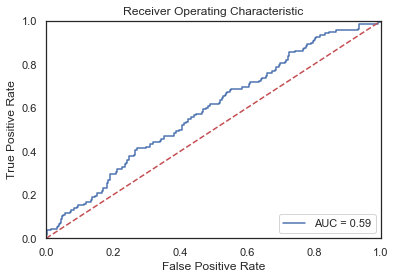

In [20]:
probs = model.predict_proba(data)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 5.	Постройте предсказания для тестового множества.

Необходимо разделить данные на тестовые и тренировочные,

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

In [22]:
# Повторяем код обучения и предсказывания, но обучаем на одном куске, а предсказываем на другом
model = LogisticRegression()                     # инициализируем модель
model.fit(X_train, y_train)                      # обучаем модель
predict = model.predict(X_test)                      # делаем предсказание

In [23]:
print('accuracy', accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

accuracy 0.7757575757575758
             precision    recall  f1-score   support

          0       0.78      0.98      0.87       129
          1       0.33      0.03      0.05        36

avg / total       0.69      0.78      0.69       165



Точность модели составляет ~78% на тестовых данных, что вполне неплохо, особенно с таким маленьким набором данных

In [24]:
model = LogisticRegression()                     # инициализируем модель
model.fit(X_train, y_train)                      # обучаем модель
predict = model.predict(X_test)                  # делаем предсказание

### 6.Сравните результаты с машинным обучением по модели случайного леса.
Для начала обучим модель случайного леса

In [25]:
model_forest = RandomForestClassifier()
model_forest.fit(X_train, y_train)
predict_forest = model_forest.predict(X_train)

print('accuracy', accuracy_score(y_train, predict_forest))
print(classification_report(y_train, predict_forest))

accuracy 0.9611940298507463
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       233
          1       1.00      0.87      0.93       102

avg / total       0.96      0.96      0.96       335



Как видно на тренировочных данных модель дала результат 97%, что больше чем по модели Логистической регрессии на 20%. Такая высокая точность модели, может означать 2 вещи, либо мы очень классные дата аналитики, либо модель просто переобучилась и на тестовых данных ее результат будет плохим.

In [26]:
model_forest = RandomForestClassifier()
model_forest.fit(X_train, y_train)
predict_forest = model_forest.predict(X_test)
print('accuracy', accuracy_score(y_test, predict_forest))
print(classification_report(y_test, predict_forest))

accuracy 0.696969696969697
             precision    recall  f1-score   support

          0       0.77      0.87      0.82       129
          1       0.15      0.08      0.11        36

avg / total       0.64      0.70      0.66       165



In [27]:
print('accuracy', accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

accuracy 0.7757575757575758
             precision    recall  f1-score   support

          0       0.78      0.98      0.87       129
          1       0.33      0.03      0.05        36

avg / total       0.69      0.78      0.69       165



Как оказалось, особой разницы между показаниями моделей нет. Логистическая регрессия очень хорошо справляется с бинарной классификацией целевого признака, однако возможно если "подергать" гиперпараметры модели случайного леса мы могли бы добится более высоких результатов, однако это занимает время и производительные мощности копьютера, в то время как логистическая регрессия дает довольно высокий результат при меньших затратах.

### 7.Выполните кросс-валидацию для случайного леса.

In [28]:
rfc = RandomForestClassifier()
cross_val_score(
    rfc,
    X_test,
    y_test,
    scoring='accuracy',
    cv=10
)

array([0.70588235, 0.76470588, 0.70588235, 0.76470588, 0.76470588,
       0.76470588, 0.8125    , 0.8125    , 0.8125    , 0.6       ])

Кросс валидация показывает довольно высокое значение для метрики оценки, которые примерно равны полученым ранее нами. Значит можно сделать вывод о том, что модел довльно точная и дает высокие показатели как на тестовой так и на тренировочной выборке.

### Вывод

Построенные модели в ходе выпонения задания дают довльно высокий результат для предсказания целевого признака, а именно - оплачен ли пост или нет. Это значит, что данные по которым делается предсткзание были выбраны верно.